In [156]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [157]:
experiment = "split_20231212"
data = "RAF005"

In [158]:
def open_df(data,experiment=experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
    df = df[3:]
    df = df.astype({
            "ID" : int,
            "TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int,
            "MIN_INTENSITY_CH1" : float,
            "MAX_INTENSITY_CH1" : float,
            "MEDIAN_INTENSITY_CH1" : float,
            "TOTAL_INTENSITY_CH1" : float,
            "STD_INTENSITY_CH1" : float,
            "CONTRAST_CH1" : float,
            "SNR_CH1" : float
            })
    return df

In [159]:
def get_filtered_ids_len(df,N=100):
    ids, len_ids = np.unique(df["TRACK_ID"].to_numpy(),return_counts=True)
    keep = np.ones(len(ids),dtype=bool)
    for i in range(len(ids)):
        keep[i] = (len_ids[i]>=N) and (len(np.unique(df[df["TRACK_ID"]==ids[i]]["FRAME"].to_numpy()))>=N)
    return ids[keep], len_ids[keep]

def traj(id,df): 
    # frames = np.sort(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    frames = np.unique(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    T = len(frames)
    pos = np.zeros((T,3))
    intensity = np.zeros(T)
    df_id = df[df["TRACK_ID"]==id]
    for t in range(T):
        pos[t,0] = df_id[df_id["FRAME"]==frames[t]]["POSITION_X"].values[0]
        pos[t,1] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Y"].values[0]
        pos[t,2] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Z"].values[0]
        intensity[t] = df_id[df_id["FRAME"]==frames[t]]["TOTAL_INTENSITY_CH1"].values[0]
    return frames, pos, intensity

def df_to_traj(data,N=100):
    df = open_df(data)
    ids, len_ids = get_filtered_ids_len(df,N=N)
    trajs = []
    for id in tqdm(ids):
        trajs.append(traj(id,df))
    return trajs
    

In [160]:
trajs_P = df_to_traj(data + "_Proximal", N=100)


/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_95906/1093890562.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
100%|██████████| 143/143 [00:17<00:00,  8.03it/s]


In [161]:
trajs_P

[(array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
          41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
          54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
          67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
          80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
          93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
         106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119, 120]),
  array([[637.000637 , 390.00039  ,   0.       ],
         [642.2006422, 379.6003796,   0.       ],
         [650.00065  , 377.000377 ,   0.       ],
         [647.4006474, 369.2003692,   0.       ],
         [655.2006552, 364.000364 ,   0.       ],
         [655.2006552, 364.000364 ,   0.       ],
         [663.000663 , 366.6003666,   0.       ],
         [663.000663 , 371.8003718,  

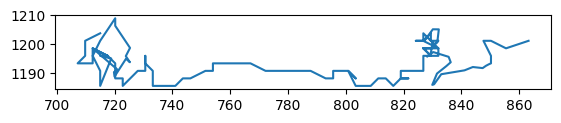

In [162]:
fig, ax = plt.subplots()
n = 20
log_intensity = np.log10(trajs_P[n][2])
log_intensity -= log_intensity.min()
log_intensity *= 0.9/log_intensity.max()
log_intensity += 0.09
# ax.scatter(trajs_P[n][1][:,0],trajs_P[n][1][:,1],alpha=log_intensity)
ax.plot(trajs_P[n][1][:,0],trajs_P[n][1][:,1])
# ax.set_xlim(0,1300)
# ax.set_ylim(0,1300)
ax.set_aspect("equal")

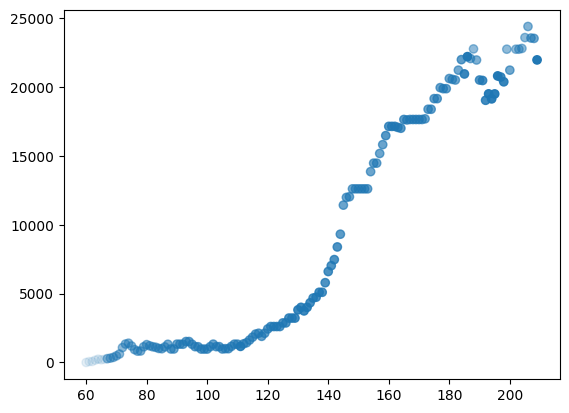

In [163]:
def SD(traj):
    frames = traj[0]
    pos = traj[1]
    T = len(frames)
    X0 = pos[0,:]
    return ((X0 - pos[:,:])**2).sum(1)

fig, ax = plt.subplots()
ax.scatter(trajs_P[n][0],SD(trajs_P[n]),alpha=log_intensity)

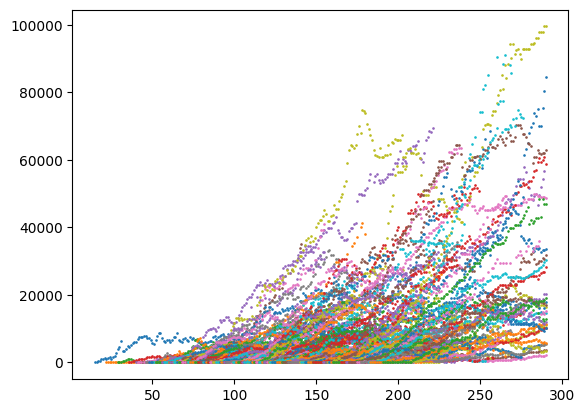

In [164]:
fig, ax = plt.subplots()
sd_f = []
for traj in trajs_P[0:]:
    ax.scatter(traj[0],SD(traj),s=0.8)
    sd_f.append(SD(traj)[99])
# ax.plot(sd_f,'.')

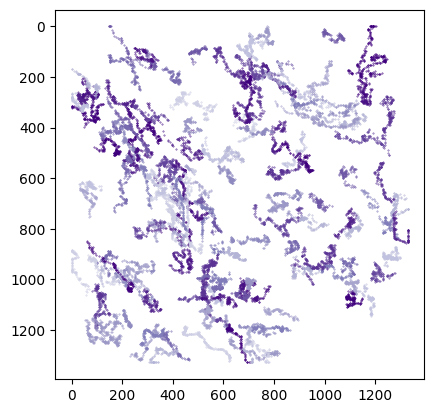

In [165]:
fig2d = plt.figure()
ax2d = fig2d.add_subplot()

N = 14
colors = plt.cm.Purples(np.linspace(0.3,1,N))
clen = len(colors)
cind = 0
for tr in trajs_P:
    ax2d.plot(tr[1][:,0],tr[1][:,1],'.',markersize=0.7,color=colors[cind%clen,:])
    cind += 1
ax2d.set_aspect("equal")
ax2d.invert_yaxis()

In [166]:
def speed_dir(traj,dt):
    frames = traj[0]
    pos = traj[1]
    speed = []
    direct = []
    t = 0 
    while t+dt<len(frames): 
        speed.append(np.linalg.norm(pos[t+dt,:-1] - pos[t,:-1])/(frames[t+dt] - frames[t]))
        direct.append(np.arctan2(pos[t+dt,1] - pos[t,1],pos[t+dt,0] - pos[t,0]))
        t += dt
    return np.array(speed), np.array(direct)

In [167]:
speed, direct = speed_dir(trajs_P[0],5)

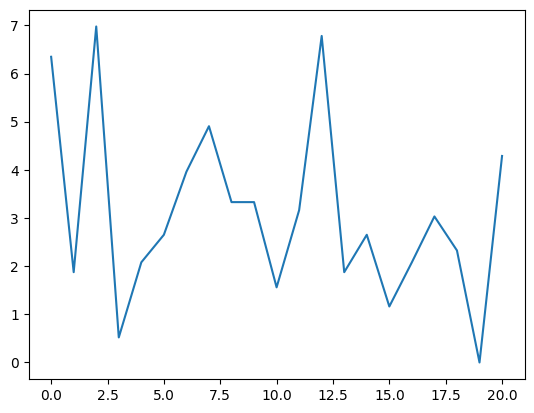

In [168]:
plt.plot(speed)

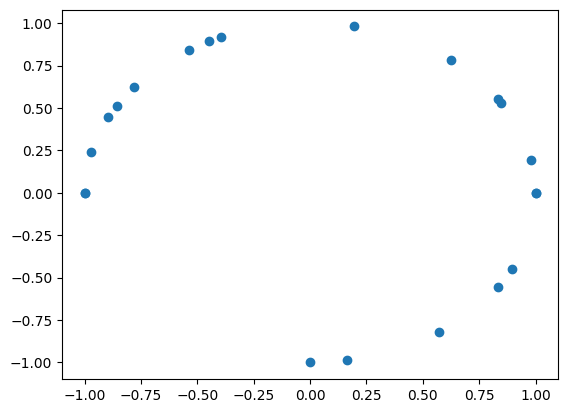

In [169]:
plt.scatter(np.cos(direct),np.sin(direct))


(0.0, 1.0)

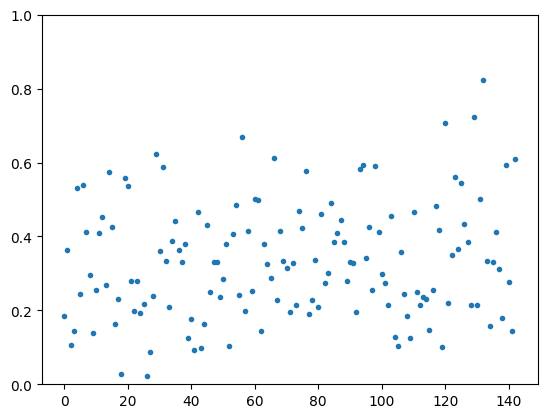

In [170]:
kappa = []
leng = []
for traj in trajs_P:
    speed, direct = speed_dir(traj,5)
    # print(len(direct))
    leng.append(len(direct))
    kappa.append(np.linalg.norm(np.mean(np.c_[np.cos(direct),np.sin(direct)],axis=0)))
    
plt.plot(kappa,'.')
plt.ylim(0,1)
# plt.plot(leng,kappa,'.')

In [171]:
leng

[21,
 28,
 19,
 28,
 36,
 21,
 22,
 25,
 30,
 31,
 48,
 21,
 21,
 28,
 19,
 20,
 26,
 23,
 37,
 21,
 29,
 20,
 22,
 25,
 30,
 24,
 23,
 30,
 45,
 21,
 23,
 21,
 31,
 26,
 31,
 24,
 21,
 22,
 34,
 26,
 37,
 30,
 20,
 32,
 20,
 22,
 20,
 21,
 24,
 23,
 20,
 24,
 24,
 21,
 41,
 33,
 41,
 23,
 26,
 24,
 34,
 29,
 29,
 33,
 21,
 41,
 21,
 24,
 31,
 27,
 20,
 26,
 19,
 28,
 22,
 20,
 28,
 21,
 19,
 28,
 37,
 19,
 19,
 34,
 21,
 23,
 21,
 25,
 22,
 30,
 24,
 23,
 19,
 35,
 21,
 29,
 30,
 31,
 34,
 35,
 28,
 20,
 25,
 23,
 22,
 22,
 21,
 21,
 27,
 29,
 33,
 26,
 21,
 22,
 20,
 31,
 31,
 21,
 30,
 22,
 29,
 25,
 28,
 28,
 27,
 26,
 26,
 22,
 22,
 23,
 26,
 26,
 26,
 25,
 24,
 24,
 20,
 22,
 21,
 21,
 20,
 21,
 19]